In [1]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
import bisect
from pyomo.opt import SolverStatus, TerminationCondition

In [2]:
def nc_underest(new_lb, new_ub, v_list, model_list, add_node_num=0, n_samples=5, tolerance=1e-8):
    """
    Parameters:
        delta (float): range of variable
        n_samples (float): number of sample nodes
        v_list (list): list of scenario functions  
        model: model with submodels corresponds to each scenario
        tolerance (float): decide when to stop

    Returns: delta (float): delta
             errors (float): hausdorff error
             y_nodes (list): y node (to make plot)
             as_nodes_list[0] (list): As node value (to make plot)
             ms_list[0] (float): ms for first scenario (to make plot)
    """
    N = len(model_list) 
    y_nodes = np.linspace(new_lb, new_ub, n_samples).tolist()
    lst = np.ones(N).tolist()
    y_opt_list = np.ones(N).tolist() 
    as_nodes_list = np.ones(N).tolist() 
    ms_list = np.ones(N).tolist() 
    eff_node_count = 0
    new_nodes_list = [None] * N
    
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-9
    solver.options['OptimalityTol'] = 1e-9
    solver.options['NonConvex'] = 2 

        
    # reset bounds
    for i in range(N):
        model_list[i].y.setlb(new_lb)
        model_list[i].y.setub(new_ub)
    
    print('start')
    for k in range(add_node_num+1):
        print('Adding node ',k)
        for i in range(N):
            print('Solving scenario ',i)
            # calculate interpolation points
            as_nodes_list[i] = [v_list[i](y) for y in y_nodes]
        
            # define piecewise function for each scenario
            if hasattr(model_list[i], 'As'):
                model_list[i].del_component('As')
            if hasattr(model_list[i], 'pw'):
                model_list[i].del_component('pw')
            if hasattr(model_list[i], 'obj'):
                model_list[i].del_component('obj')
            model_list[i].As = Var()
            model_list[i].pw = Piecewise(
                model_list[i].As, model_list[i].y,
                pw_pts=y_nodes,
                f_rule=as_nodes_list[i],
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )

            # set ip objective for each scenario and solve
            model_list[i].obj = Objective(expr=model_list[i].obj_expr - model_list[i].As, sense=minimize)
            results = solver.solve(model_list[i])
            ms_list[i] = results.problem.lower_bound
            
            # check if new node is too close to old nodes         
            if (k > 0) and (abs(new_nodes_list[i] - value(model_list[i].y)) <= 1e-6):
                print("The new node is too close and not inserted")
                break
                
            # insert new nodes
            new_nodes_list[i] = value(model_list[i].y)
            if (new_nodes_list[i] not in y_nodes) and (k != add_node_num):
                bisect.insort(y_nodes, new_nodes_list[i])
                eff_node_count += 1

    # define and solve the sum model
    assum_nodes = np.sum(as_nodes_list, axis=0)
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(new_lb, new_ub))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=list(assum_nodes),
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
    results = solver.solve(model_sum)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        pass
    else:
        print("Sum model doesn't get solved normally")
    # get the output
    errors = results.problem.lower_bound + sum(ms_list)
    errors = -errors
    
    # calculate the diameter
    delta = (new_ub-new_lb)/2
    return delta, errors, y_nodes, as_nodes_list[0], ms_list[0],as_nodes_list[1], ms_list[1],eff_node_count

In [8]:
# build function for each scenario
def v_1(y):  
    return - np.sqrt(np.abs(y))

def v_2(y): 
    return np.sqrt(np.abs(y))

v_list = [v_1, v_2]

# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(-1, 1))
m1.x1 = Var(bounds=(0, 1))
m1.x11 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x11**2 == m1.y**2)
m1.c2 = Constraint(expr=m1.x11 == (m1.x1)**2)
m1.obj_expr = Expression(expr=-m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(-1, 1))
m2.x2 = Var(bounds=(0, 1))
m2.c1 = Constraint(expr=m2.x2**2 >= m2.y)
m2.c2 = Constraint(expr=m2.x2**2 >= -m2.y)
m2.obj_expr = Expression(expr=m2.x2)

model_list = [m1, m2]
# lower bound and upper bound
ylb = -0.2
yub = 0.2

# Plot the figures and error

In [9]:
# make delta list
adds = np.arange(0, 30)
results = [nc_underest(ylb,yub,v_list,[m1,m2],a) for a in adds]

start
Adding node  0
Solving scenario  0
Solving scenario  1
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
Adding node  2
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 

start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
Adding node  2
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  3
Solving scenario  0
Solving scenario  1
Adding node  4
Solving scenario  0
Solving scenario  1
Adding node  5
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  6
Solving scenario  0
Solving scenario  1
Adding node  7
Solving scenario  0
Solving scenario  1
Adding node  8
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  9
Solving scenario  0
Solving scenario  1
Adding node  10
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  11
Solving scenario  0
Solving scenario  1
Adding node  12
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
**WARNING: Piecewise component 'pw[(None,)]' has detected slo

Solving scenario  1
Adding node  5
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  6
Solving scenario  0
Solving scenario  1
Adding node  7
Solving scenario  0
Solving scenario  1
Adding node  8
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  9
Solving scenario  0
Solving scenario  1
Adding node  10
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  11
Solving scenario  0
Solving scenario  1
Adding node  12
Solving scenario  0
Solving scenario  1
Adding node  13
Solving scenario  0
Solving scenario  1
Adding node  14
Solving scenario  0
Solving scenario  1
Adding node  15
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  16
Solving scenario  0
Solving scenario  1
Adding node  17
Solving scenario  0
Solving scenario  1
Adding node  18
Solving scenario  0
Solving scenario  1
The new node is too close and

start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
Adding node  2
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  3
Solving scenario  0
Solving scenario  1
Adding node  4
Solving scenario  0
Solving scenario  1
Adding node  5
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  6
Solving scenario  0
Solving scenario  1
Adding node  7
Solving scenario  0
Solving scenario  1
Adding node  8
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  9
Solving scenario  0
Solving scenario  1
Adding node  10
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  11
Solving scenario  0
Solving scenario  1
Adding node  12
Solving scenario  0
Solving scenario  1
Adding node  13
Solving scenario  0
Solving scenario  1
Adding node  14
Solving scenario  0
Solving scen

start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
Adding node  2
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  3
Solving scenario  0
Solving scenario  1
Adding node  4
Solving scenario  0
Solving scenario  1
Adding node  5
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  6
Solving scenario  0
Solving scenario  1
Adding node  7
Solving scenario  0
Solving scenario  1
Adding node  8
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  9
Solving scenario  0
Solving scenario  1
Adding node  10
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  11
Solving scenario  0
Solving scenario  1
Adding node  12
Solving scenario  0
Solving scenario  1
Adding node  13
Solving scenario  0
Solving scenario  1
Adding node  14
Solving scenario  0
Solving scen

   
   
   
effective add node num  0
y node is  [-1.  -0.5  0.   0.5  1. ]
y node length 5
ms value is  -0.17677680120244868
y_opt value is  [1.0, 0.7071067811865476, 0.0, 0.7071067811865476, 1.0]


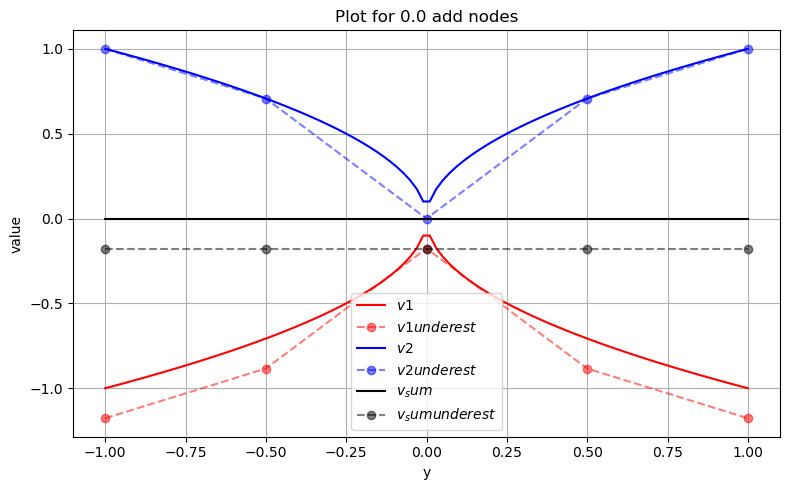

   
   
   
effective add node num  1
y node is  [-1.         -0.5        -0.12500806  0.          0.5         1.        ]
y node length 6
ms value is  -0.17677669814308897
y_opt value is  [1.0, 0.7071067811865476, 0.3535647877460823, 0.0, 0.7071067811865476, 1.0]


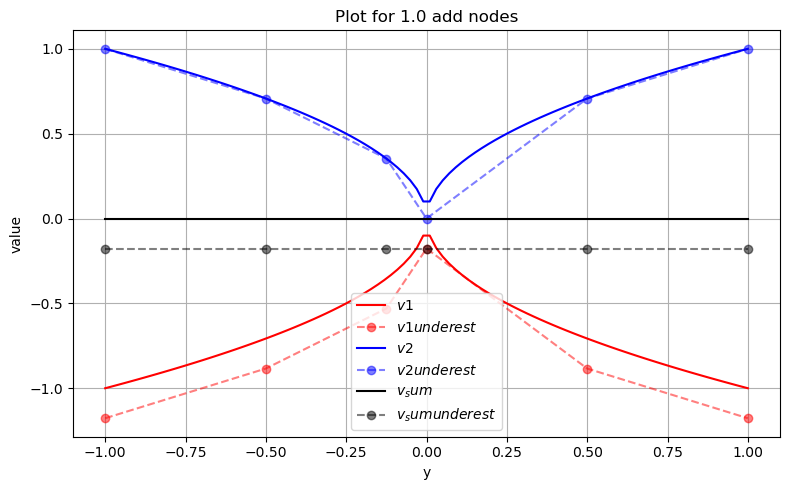

   
   
   
effective add node num  3
y node is  [-1.         -0.5        -0.12500806  0.          0.12498955  0.12498955
  0.5         1.        ]
y node length 8
ms value is  -0.08839120505394711
y_opt value is  [1.0, 0.7071067811865476, 0.3535647877460823, 0.0, 0.35353861667410136, 0.3535386166741079, 0.7071067811865476, 1.0]


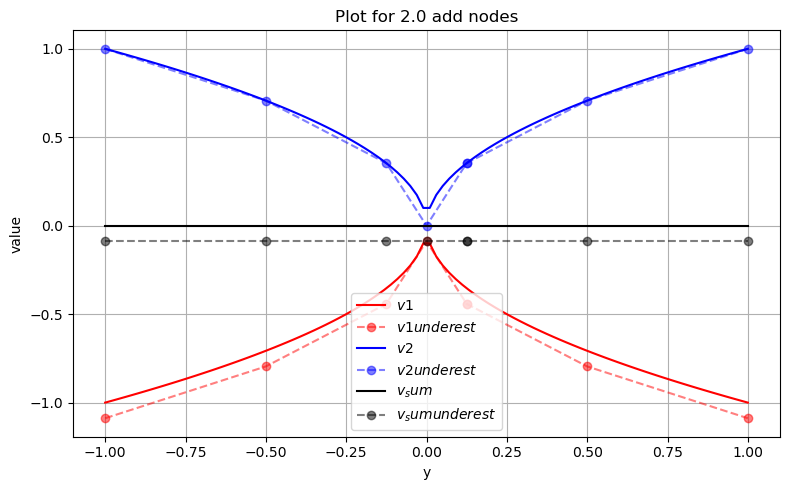

   
   
   
effective add node num  4
y node is  [-1.         -0.5        -0.12500806 -0.0312509   0.          0.12498955
  0.12498955  0.5         1.        ]
y node length 9
ms value is  -0.08838676015493087
y_opt value is  [1.0, 0.7071067811865476, 0.3535647877460823, 0.17677925033844658, 0.0, 0.35353861667410136, 0.3535386166741079, 0.7071067811865476, 1.0]


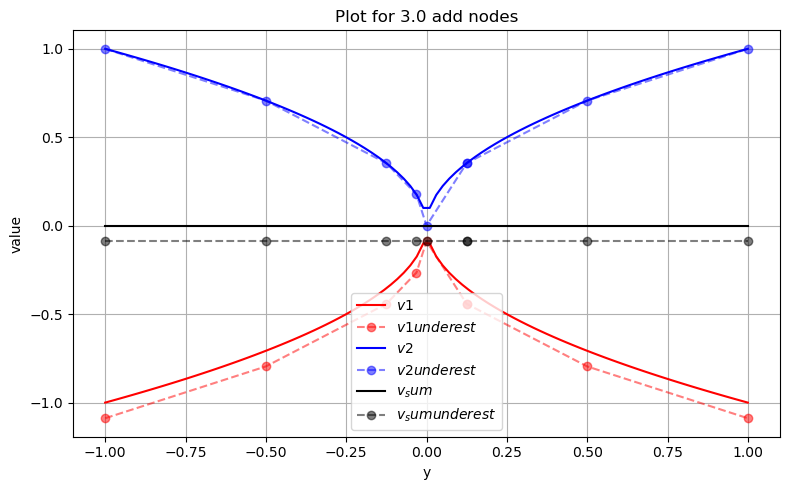

   
   
   
effective add node num  5
y node is  [-1.         -0.5        -0.12500806 -0.0312509   0.          0.03117148
  0.12498955  0.12498955  0.5         1.        ]
y node length 10
ms value is  -0.0441949938278159
y_opt value is  [1.0, 0.7071067811865476, 0.3535647877460823, 0.17677925033844658, 0.0, 0.17655447524317905, 0.35353861667410136, 0.3535386166741079, 0.7071067811865476, 1.0]


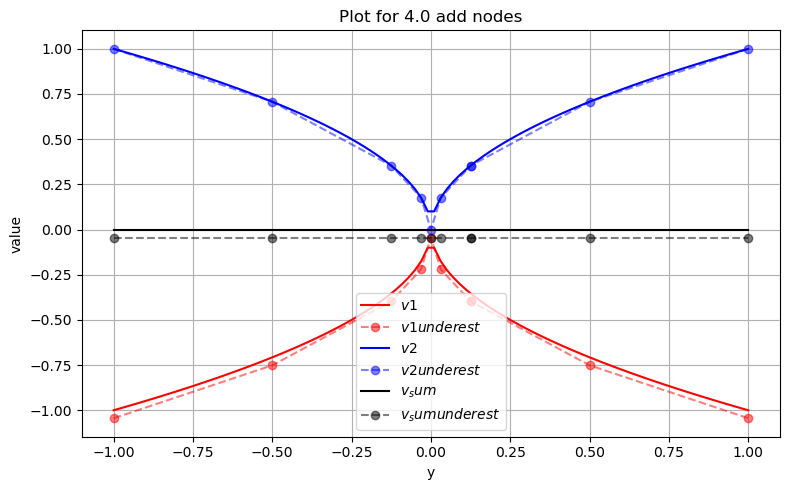

   
   
   
effective add node num  6
y node is  [-1.         -0.5        -0.12500806 -0.0312509  -0.00782894  0.
  0.03117148  0.12498955  0.12498955  0.5         1.        ]
y node length 11
ms value is  -0.04414213789805893
y_opt value is  [1.0, 0.7071067811865476, 0.3535647877460823, 0.17677925033844658, 0.08848127513223354, 0.0, 0.17655447524317905, 0.35353861667410136, 0.3535386166741079, 0.7071067811865476, 1.0]


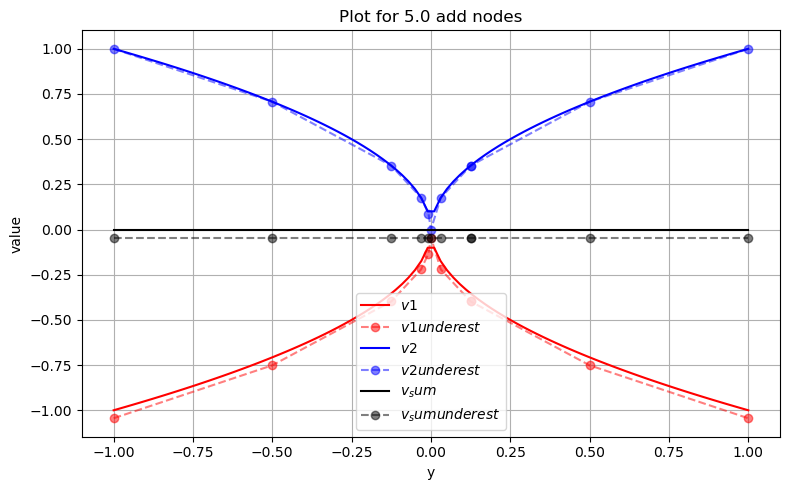

   
   
   
effective add node num  7
y node is  [-1.         -0.5        -0.12500806 -0.0312509  -0.00782894  0.
  0.00780573  0.03117148  0.12498955  0.12498955  0.5         1.        ]
y node length 12
ms value is  -0.029465658531964367
y_opt value is  [1.0, 0.7071067811865476, 0.3535647877460823, 0.17677925033844658, 0.08848127513223354, 0.0, 0.08835004002606701, 0.17655447524317905, 0.35353861667410136, 0.3535386166741079, 0.7071067811865476, 1.0]


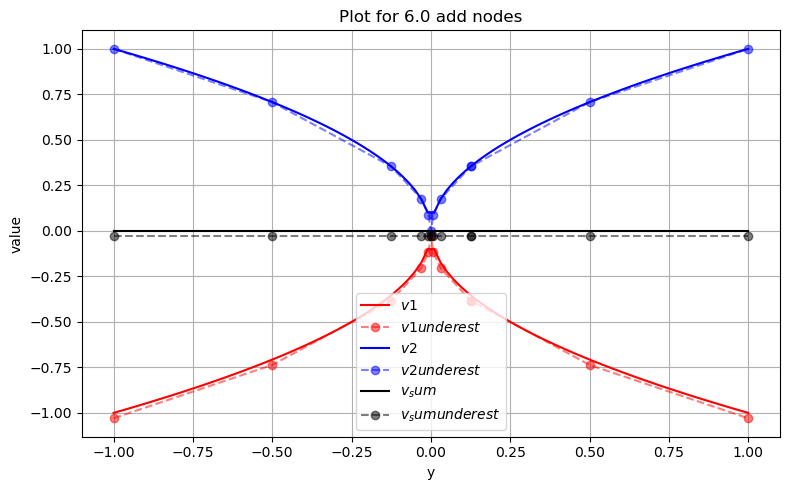

   
   
   
effective add node num  8
y node is  [-1.         -0.5        -0.12500806 -0.0312509  -0.00782894  0.
  0.00780573  0.03117148  0.12498955  0.12498955  0.28125298  0.5
  1.        ]
y node length 13
ms value is  -0.02946056932290686
y_opt value is  [1.0, 0.7071067811865476, 0.3535647877460823, 0.17677925033844658, 0.08848127513223354, 0.0, 0.08835004002606701, 0.17655447524317905, 0.35353861667410136, 0.3535386166741079, 0.5303328998892548, 0.7071067811865476, 1.0]


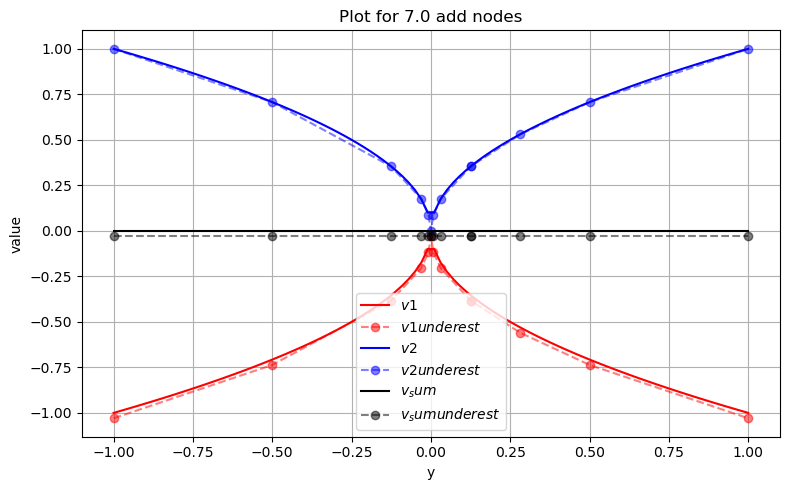

   
   
   
effective add node num  9
y node is  [-1.         -0.5        -0.28128027 -0.12500806 -0.0312509  -0.00782894
  0.          0.00780573  0.03117148  0.12498955  0.12498955  0.28125298
  0.5         1.        ]
y node length 14
ms value is  -0.022122005665908127
y_opt value is  [1.0, 0.7071067811865476, 0.5303586272104659, 0.3535647877460823, 0.17677925033844658, 0.08848127513223354, 0.0, 0.08835004002606701, 0.17655447524317905, 0.35353861667410136, 0.3535386166741079, 0.5303328998892548, 0.7071067811865476, 1.0]


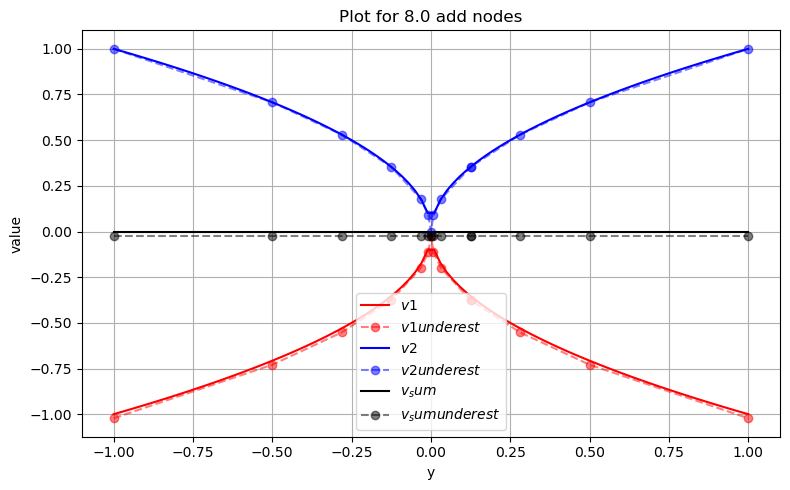

   
   
   
effective add node num  10
y node is  [-1.         -0.5        -0.28128027 -0.12500806 -0.0312509  -0.00782894
 -0.00194861  0.          0.00780573  0.03117148  0.12498955  0.12498955
  0.28125298  0.5         1.        ]
y node length 15
ms value is  -0.022090078463353174
y_opt value is  [1.0, 0.7071067811865476, 0.5303586272104659, 0.3535647877460823, 0.17677925033844658, 0.08848127513223354, 0.04414308236728391, 0.0, 0.08835004002606701, 0.17655447524317905, 0.35353861667410136, 0.3535386166741079, 0.5303328998892548, 0.7071067811865476, 1.0]


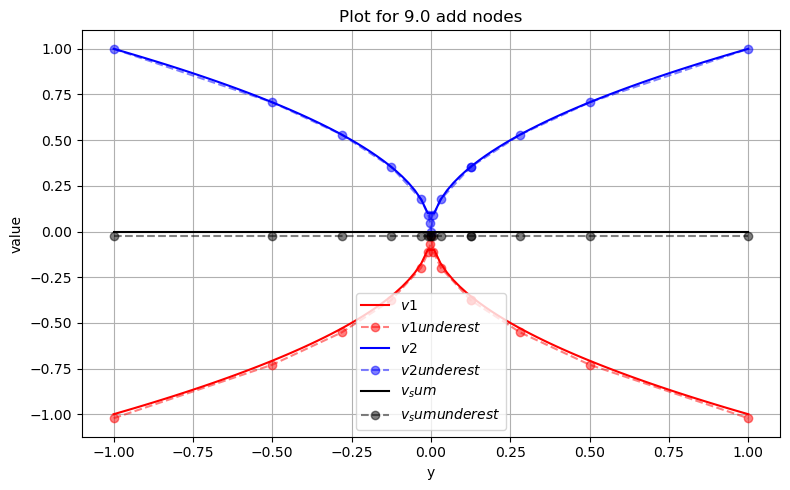

   
   
   
effective add node num  11
y node is  [-1.         -0.5        -0.28128027 -0.12500806 -0.0312509  -0.00782894
 -0.00194861  0.          0.00194675  0.00780573  0.03117148  0.12498955
  0.12498955  0.28125298  0.5         1.        ]
y node length 16
ms value is  -0.014772591732484491
y_opt value is  [1.0, 0.7071067811865476, 0.5303586272104659, 0.3535647877460823, 0.17677925033844658, 0.08848127513223354, 0.04414308236728391, 0.0, 0.04412204604780047, 0.08835004002606701, 0.17655447524317905, 0.35353861667410136, 0.3535386166741079, 0.5303328998892548, 0.7071067811865476, 1.0]


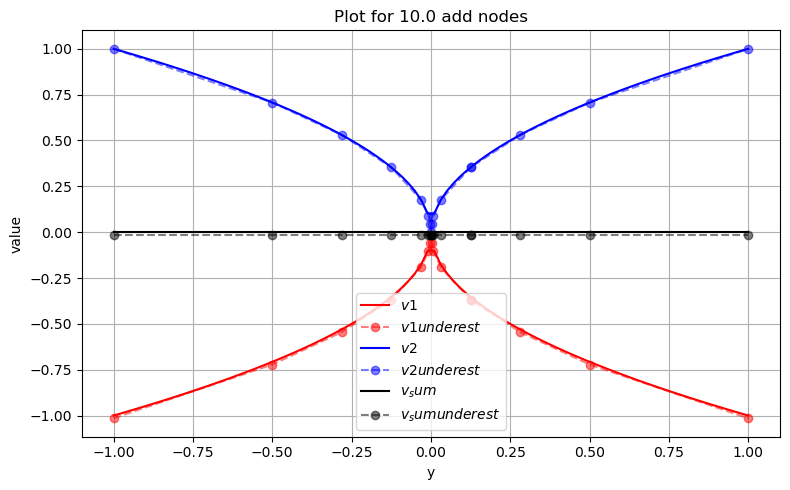

   
   
   
effective add node num  12
y node is  [-1.         -0.5        -0.28128027 -0.12500806 -0.0312509  -0.00782894
 -0.00194861  0.          0.00194675  0.00780573  0.03117148  0.07024876
  0.12498955  0.12498955  0.28125298  0.5         1.        ]
y node length 17
ms value is  -0.014732484380785074
y_opt value is  [1.0, 0.7071067811865476, 0.5303586272104659, 0.3535647877460823, 0.17677925033844658, 0.08848127513223354, 0.04414308236728391, 0.0, 0.04412204604780047, 0.08835004002606701, 0.17655447524317905, 0.26504481899627996, 0.35353861667410136, 0.3535386166741079, 0.5303328998892548, 0.7071067811865476, 1.0]


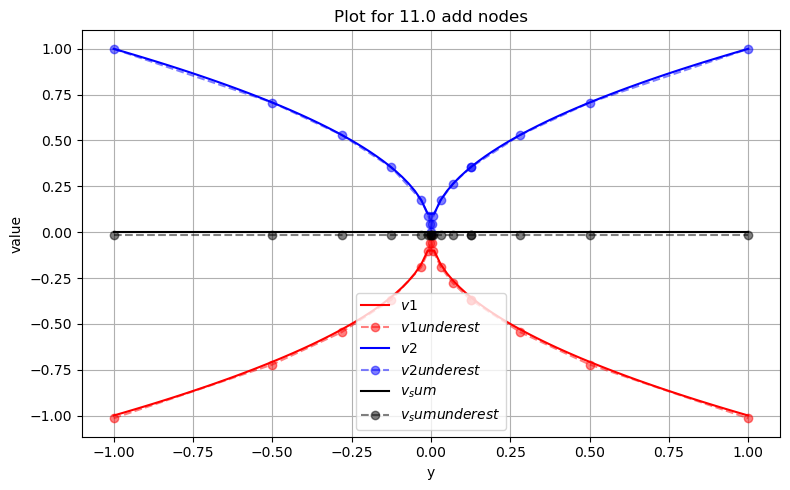

   
   
   
effective add node num  13
y node is  [-1.         -0.5        -0.28128027 -0.12500806 -0.07032658 -0.0312509
 -0.00782894 -0.00194861  0.          0.00194675  0.00780573  0.03117148
  0.07024876  0.12498955  0.12498955  0.28125298  0.5         1.        ]
y node length 18
ms value is  -0.012563166441102502
y_opt value is  [1.0, 0.7071067811865476, 0.5303586272104659, 0.3535647877460823, 0.2651915979854406, 0.17677925033844658, 0.08848127513223354, 0.04414308236728391, 0.0, 0.04412204604780047, 0.08835004002606701, 0.17655447524317905, 0.26504481899627996, 0.35353861667410136, 0.3535386166741079, 0.5303328998892548, 0.7071067811865476, 1.0]


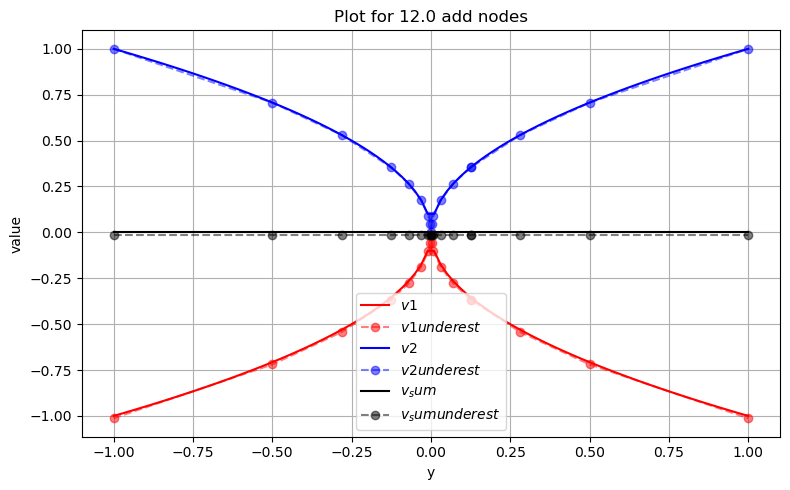

   
   
   
effective add node num  14
y node is  [-1.         -0.5        -0.28128027 -0.12500806 -0.07032658 -0.0312509
 -0.00782894 -0.00194861  0.          0.00194675  0.00780573  0.03117148
  0.07024876  0.12498955  0.12498955  0.28125298  0.5         0.72854509
  1.        ]
y node length 19
ms value is  -0.012563133388190817
y_opt value is  [1.0, 0.7071067811865476, 0.5303586272104659, 0.3535647877460823, 0.2651915979854406, 0.17677925033844658, 0.08848127513223354, 0.04414308236728391, 0.0, 0.04412204604780047, 0.08835004002606701, 0.17655447524317905, 0.26504481899627996, 0.35353861667410136, 0.3535386166741079, 0.5303328998892548, 0.7071067811865476, 0.8535485255571272, 1.0]


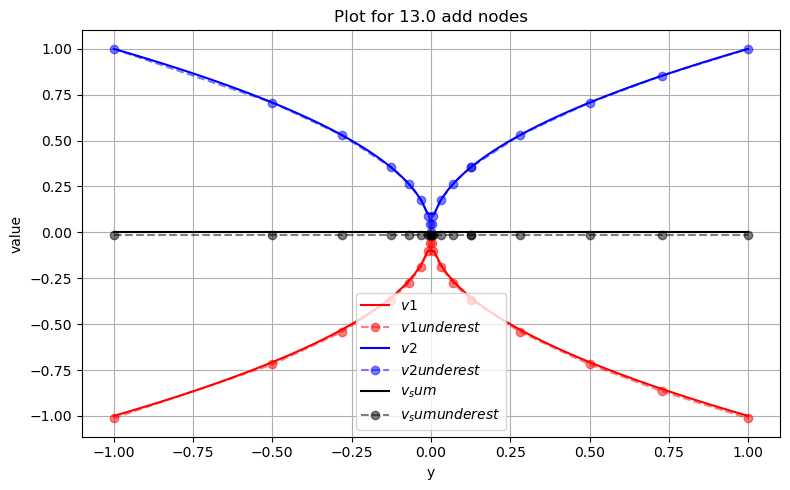

   
   
   
effective add node num  15
y node is  [-1.         -0.72854367 -0.5        -0.28128027 -0.12500806 -0.07032658
 -0.0312509  -0.00782894 -0.00194861  0.          0.00194675  0.00780573
  0.03117148  0.07024876  0.12498955  0.12498955  0.28125298  0.5
  0.72854509  1.        ]
y node length 20
ms value is  -0.011054165823840232
y_opt value is  [1.0, 0.8535476992692124, 0.7071067811865476, 0.5303586272104659, 0.3535647877460823, 0.2651915979854406, 0.17677925033844658, 0.08848127513223354, 0.04414308236728391, 0.0, 0.04412204604780047, 0.08835004002606701, 0.17655447524317905, 0.26504481899627996, 0.35353861667410136, 0.3535386166741079, 0.5303328998892548, 0.7071067811865476, 0.8535485255571272, 1.0]


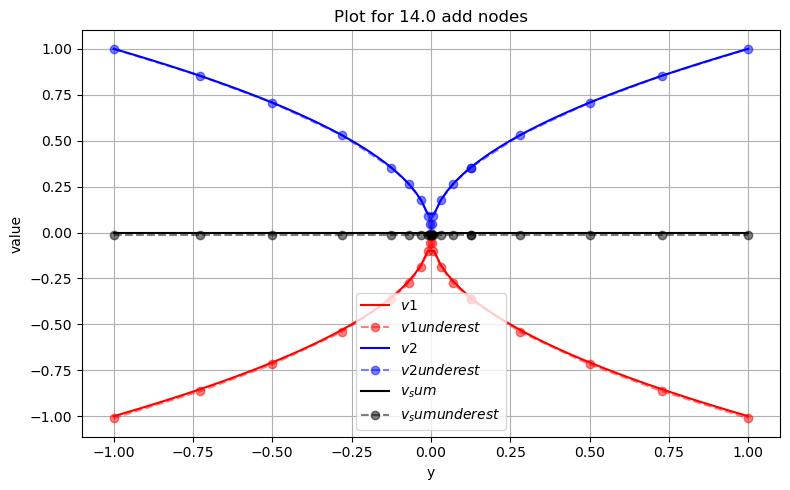

In [5]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][-3])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][-2]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    print('effective add node num ',results[i][-1])
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print("ms value is ",results[i][4])
    print("y_opt value is ",results[i][5])

    # make the plot
    plt.figure(figsize=(8, 5))
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title(f"Plot for {i:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.07905817778151857, 0.07905819848367998, 0.03954386491993583, 0.03945071288047383, 0.0197715917992689, 0.019716457435225387, 0.013236895155303977, 0.013167604105592576, 0.00993727177739536, 0.009928657232587589, 0.006589821805195045, 0.006583229890659091, 0.005618419537894683, 0.005618421942304528, 0.005248488381144494, 0.005045979916682656, 0.004625395017392784, 0.003971628383837686, 0.003952274516870843, 0.003844776058602155, 0.003844776058602155, 0.003844776058602155, 0.003844776058602155, 0.003844776058602155, 0.003844776058602155, 0.003844776058602155, 0.003844776058602155, 0.003844776058602155, 0.003844776058602155, 0.003844776058602155]


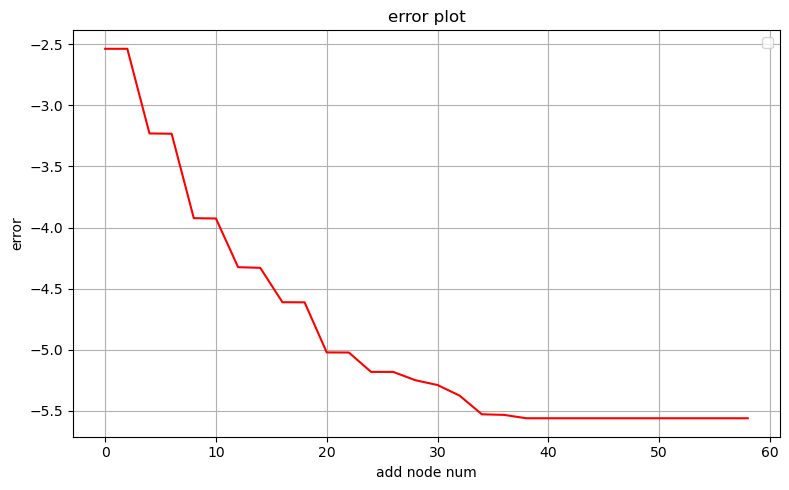

In [10]:
plt.figure(figsize=(8, 5))
errors = [item[1] for item in results]
plt.plot(2*adds, np.log(errors), color='red')

plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
print(errors)